<a href="https://colab.research.google.com/github/DEMON110/anomaly-multi-sig-protocol/blob/main/Gas_Calulationipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy tensorflow scikit-learn matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Test if the libraries are working
print("Libraries loaded successfully")

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Check Pandas version
print(f"Pandas version: {pd.__version__}")

# Check Keras version
print(f"Keras version: {keras.__version__}")


Libraries loaded successfully
TensorFlow version: 2.19.0
Pandas version: 2.2.2
Keras version: 3.10.0


In [ ]:
from google.colab import files
uploaded = files.upload()

# Then, load the CSV file
import pandas as pd
df = pd.read_csv('metaverse_transactions_dataset.csv')
print(f"Total rows in the dataset: {len(df)}")

Saving metaverse_transactions_dataset.csv to metaverse_transactions_dataset (1).csv
Total rows in the dataset: 78600


In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv("metaverse_transactions_dataset.csv")

# Example of how to handle transaction types to infer function names
def categorize_transaction(row):
    # Mapping transaction types to inferred function names and calldata lengths
    if row['transaction_type'] == 'transfer':
        return 'submit(Intent)', 64  # Example calldata length (you can adjust based on actual data)
    elif row['transaction_type'] == 'purchase':
        return 'submit(PurchaseIntent)', 128
    elif row['transaction_type'] == 'sale':
        return 'submit(SaleIntent)', 128
    elif row['transaction_type'] == 'phishing':
        return 'alert(Phishing)', 32
    elif row['transaction_type'] == 'scam':
        return 'alert(Scam)', 32
    else:
        return 'unknown', 0

# Apply the function to create new columns
df[['function_name', 'calldata_length']] = df.apply(lambda row: pd.Series(categorize_transaction(row)), axis=1)

# Add a placeholder for approvals/threshold metadata
# Assuming you have a way to track approval thresholds based on transaction type, here's an example:
def get_approval_threshold(row):
    if row['transaction_type'] in ['purchase', 'sale']:
        return 1000  # Example threshold for these types
    else:
        return 0  # No approval threshold for others

df['approval_threshold'] = df.apply(get_approval_threshold, axis=1)

# Optionally, add other inferred columns, e.g., intentHash or approvals metadata
# For example purposes, we will just add a dummy "approval" column
df['approval'] = df['approval_threshold'].apply(lambda x: True if x > 0 else False)

# Save the updated dataframe
df.to_csv("updated_metaverse_transactions.csv", index=False)

# Display the first few rows of the updated dataframe
print(df.head(78600))


             timestamp  Time (in days)  \
0      4/11/2022 12:47              12   
1      6/14/2022 19:12              19   
2      1/18/2022 16:26              16   
3       6/15/2022 9:20               9   
4      2/18/2022 14:35              14   
...                ...             ...   
78595  2/13/2022 12:52              12   
78596  2/16/2022 16:15              16   
78597   8/4/2022 16:06              16   
78598   2/26/2022 4:06               4   
78599  6/25/2022 14:27              14   

                                  sending_address  \
0      0x9d32d0bf2c00f41ce7ca01b66e174cc4dcb0c1da   
1      0xd6e251c23cbf52dbd472f079147873e655d8096f   
2      0x2e0925b922fed01f6a85d213ae2718f54b8ca305   
3      0x93efefc25fcaf31d7695f28018d7a11ece55457f   
4      0xad3b8de45d63f5cce28aef9a82cf30c397c6ceb9   
...                                           ...   
78595  0xa99b9a7f5c5dd37429771efd3b93c6fbe1ab2936   
78596  0xcca095ad2d508c200bda1141f783d77c3e6cbb08   
78597  0xe0b340171

In [ ]:
from google.colab import files
files.download("updated_metaverse_transactions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dataset loaded successfully.
Columns in dataset: ['timestamp', 'Time (in days)', 'sending_address', 'receiving_address', 'gas (Etherum)', 'transaction_type', 'location_region', 'ip_prefix', 'login_frequency', 'session_duration', 'purchase_pattern', 'age_group', 'risk_score', 'anomaly', 'function_name', 'calldata_length', 'approval_threshold', 'approval']
Operation column value counts:
operation
submit    72105
None       6495
Name: count, dtype: int64

Trace Preview:
  operation    gas_used  calldata_bytes  approvals_required run_identifier
0    submit  796.949206              64                   0       transfer
1    submit    0.010000             128                1000       purchase
2    submit  778.197390             128                1000       purchase
3    submit  300.838358              64                   0       transfer
4    submit  775.569344             128                1000           sale

Median and IQR for gas_used by run_identifier:
  run_identifier  median_gas_u

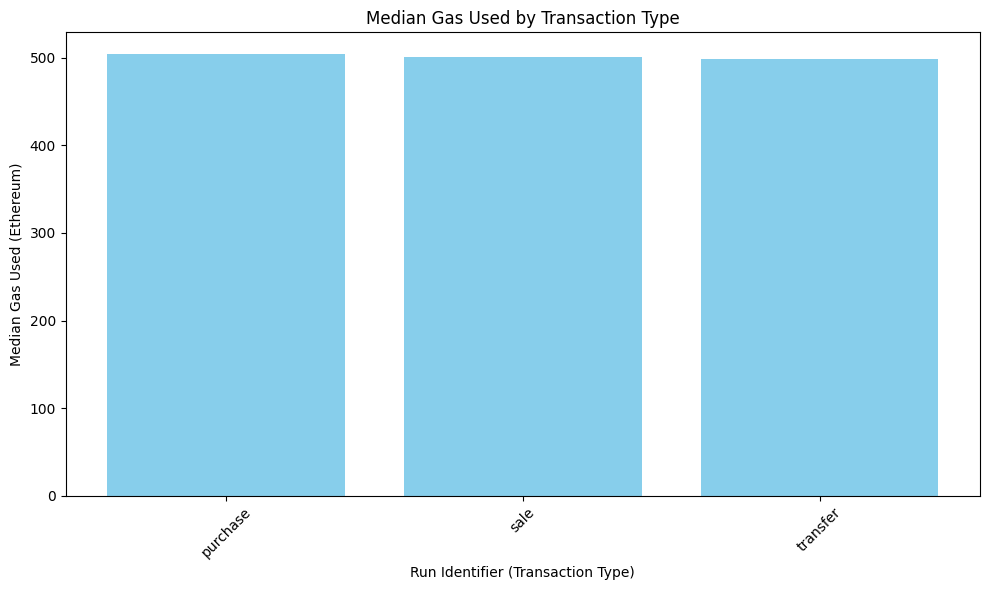

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np

# Load the dataset
try:
    df = pd.read_csv('updated_metaverse_transactions.csv')
    print("Dataset loaded successfully.")
    print("Columns in dataset:", df.columns.tolist())
except FileNotFoundError:
    print("Error: 'updated_metaverse_transactions_.csv' not found. Please upload the file to Colab.")
    raise
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

# Verify required columns
required_columns = ['function_name', 'gas (Etherum)', 'calldata_length', 'approval_threshold', 'transaction_type', 'approval']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"Error: Missing columns in dataset: {missing_columns}")
    raise KeyError(f"Missing columns: {missing_columns}")

# Step 1: Map function_name and approval to operation
def map_operation(function_name, approval):
    function_name = str(function_name).lower()  # Convert to string and lowercase to handle potential issues
    if 'submit' in function_name:
        return 'submit'
    elif approval:  # Assume approval=True indicates an 'approve' operation
        return 'approve'
    return None  # Exclude other cases (e.g., alert(Phishing), alert(Scam))

# Apply mapping
df['operation'] = df.apply(lambda x: map_operation(x['function_name'], x['approval']), axis=1)

# Debug: Check operation column values
print("Operation column value counts:")
print(df['operation'].value_counts(dropna=False))

# Step 2: Create the trace with required fields
trace_df = df[df['operation'].notnull()][[
    'function_name',  # Temporary for verification
    'gas (Etherum)',
    'calldata_length',
    'approval_threshold',
    'transaction_type'
]].copy()

# Check if trace_df is empty
if trace_df.empty:
    print("Error: No rows remain after filtering for non-null operations. Check 'function_name' and 'approval' values.")
    raise ValueError("Filtered DataFrame is empty.")

# Rename columns to match requested fields
trace_df = trace_df.rename(columns={
    'gas (Etherum)': 'gas_used',
    'calldata_length': 'calldata_bytes',
    'approval_threshold': 'approvals_required',
    'transaction_type': 'run_identifier'
})

# Add operation column to trace_df
trace_df['operation'] = df[df['operation'].notnull()]['operation']

# Select only the required fields
trace_df = trace_df[['operation', 'gas_used', 'calldata_bytes', 'approvals_required', 'run_identifier']]

# Step 3: Compute medians and IQRs for gas_used per run_identifier
stats = trace_df.groupby('run_identifier')['gas_used'].agg(
    median_gas_used='median',
    q1_gas_used=lambda x: np.percentile(x, 25),
    q3_gas_used=lambda x: np.percentile(x, 75)
).reset_index()

# Calculate IQR
stats['iqr_gas_used'] = stats['q3_gas_used'] - stats['q1_gas_used']

# Step 4: Export the trace to a CSV file
trace_df.to_csv('metaverse_transaction_trace.csv', index=False)

# Display the first few rows of the trace
print("\nTrace Preview:")
print(trace_df.head())

# Display the median and IQR statistics
print("\nMedian and IQR for gas_used by run_identifier:")
print(stats)

# Save the statistics to a separate CSV file
stats.to_csv('gas_used_statistics.csv', index=False)

# Optional: Plot median gas_used by run_identifier
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(stats['run_identifier'], stats['median_gas_used'], color='skyblue')
plt.xlabel('Run Identifier (Transaction Type)')
plt.ylabel('Median Gas Used (Ethereum)')
plt.title('Median Gas Used by Transaction Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np

# Load the dataset
try:
    df = pd.read_csv('updated_metaverse_transactions.csv')
    print("Dataset loaded successfully.")
    print("Columns in dataset:", df.columns.tolist())
except FileNotFoundError:
    print("Error: 'updated_metaverse_transactions_.csv' not found. Please upload the file to Colab.")
    raise
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

# Verify required columns
required_columns = ['function_name', 'gas (Etherum)', 'calldata_length', 'approval_threshold', 'transaction_type', 'approval']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"Error: Missing columns in dataset: {missing_columns}")
    raise KeyError(f"Missing columns: {missing_columns}")

# Step 1: Map function_name and approval to operation
def map_operation(function_name, approval):
    function_name = str(function_name).lower()  # Convert to string and lowercase to handle potential issues
    if 'submit' in function_name:
        return 'submit'
    elif approval:  # Assume approval=True indicates an 'approve' operation
        return 'approve'
    return None  # Exclude other cases (e.g., alert(Phishing), alert(Scam))

# Apply mapping
df['operation'] = df.apply(lambda x: map_operation(x['function_name'], x['approval']), axis=1)

# Step 2: Create the trace with required fields
trace_df = df[df['operation'].notnull()][[
    'function_name',  # Temporary for verification
    'gas (Etherum)',
    'calldata_length',
    'approval_threshold',
    'transaction_type'
]].copy()

# Check if trace_df is empty
if trace_df.empty:
    print("Error: No rows remain after filtering for non-null operations. Check 'function_name' and 'approval' values.")
    raise ValueError("Filtered DataFrame is empty.")

# Rename columns to match requested fields
trace_df = trace_df.rename(columns={
    'gas (Etherum)': 'gas_used',
    'calldata_length': 'calldata_bytes',
    'approval_threshold': 'approvals_required',
    'transaction_type': 'run_identifier'
})

# Add operation column to trace_df
trace_df['operation'] = df[df['operation'].notnull()]['operation']

# Select only the gas_used column
gas_used_data = trace_df['gas_used']

# Display the gas_used data
print("\nGas Used Data:")
print(gas_used_data)

# Save the gas_used data to a CSV file
gas_used_data.to_csv('gas_used_data.csv', index=False)

Dataset loaded successfully.
Columns in dataset: ['timestamp', 'Time (in days)', 'sending_address', 'receiving_address', 'gas (Etherum)', 'transaction_type', 'location_region', 'ip_prefix', 'login_frequency', 'session_duration', 'purchase_pattern', 'age_group', 'risk_score', 'anomaly', 'function_name', 'calldata_length', 'approval_threshold', 'approval']

Gas Used Data:
0        796.949206
1          0.010000
2        778.197390
3        300.838358
4        775.569344
            ...    
78595    660.280373
78596    310.273397
78597    624.674332
78598    401.391592
78599    523.947956
Name: gas_used, Length: 72105, dtype: float64


In [ ]:
from google.colab import files
files.download("gas_used_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
try:
    df = pd.read_csv('updated_metaverse_transactions.csv')
    print("Dataset loaded successfully.")
    print("Columns in dataset:", df.columns.tolist())
except FileNotFoundError:
    print("Error: 'updated_metaverse_transactions_.csv' not found. Please upload the file to Colab.")
    raise
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

# Verify required columns
required_columns = ['function_name', 'gas (Etherum)', 'calldata_length', 'approval_threshold', 'transaction_type', 'approval']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"Error: Missing columns in dataset: {missing_columns}")
    raise KeyError(f"Missing columns: {missing_columns}")

# Step 1: Map function_name and approval to operation
def map_operation(function_name, approval):
    function_name = str(function_name).lower()  # Convert to string and lowercase to handle potential issues
    if 'submit' in function_name:
        return 'submit'
    elif approval:  # Assume approval=True indicates an 'approve' operation
        return 'approve'
    return None  # Exclude other cases (e.g., alert(Phishing), alert(Scam))

# Apply mapping
df['operation'] = df.apply(lambda x: map_operation(x['function_name'], x['approval']), axis=1)

# Step 2: Create the trace with required fields
trace_df = df[df['operation'].notnull()][[
    'function_name',  # Temporary for verification
    'gas (Etherum)',
    'calldata_length',
    'approval_threshold',
    'transaction_type'
]].copy()

# Check if trace_df is empty
if trace_df.empty:
    print("Error: No rows remain after filtering for non-null operations. Check 'function_name' and 'approval' values.")
    raise ValueError("Filtered DataFrame is empty.")

# Rename columns to match requested fields
trace_df = trace_df.rename(columns={
    'gas (Etherum)': 'gas_used',
    'calldata_length': 'calldata_bytes',
    'approval_threshold': 'approvals_required',
    'transaction_type': 'run_identifier'
})

# Add operation column to trace_df
trace_df['operation'] = df[df['operation'].notnull()]['operation']

# Add id column (incremental index starting from 1)
trace_df['id'] = range(1, len(trace_df) + 1)

# Select only the id and gas_used columns
gas_used_with_id = trace_df[['id', 'gas_used']]

# Display the gas_used data with id
print("\nGas Used Data with ID:")
print(gas_used_with_id)

# Save the gas_used data with id to a CSV file
gas_used_with_id.to_csv('gas_used_data_with_id.csv', index=False)

Dataset loaded successfully.
Columns in dataset: ['timestamp', 'Time (in days)', 'sending_address', 'receiving_address', 'gas (Etherum)', 'transaction_type', 'location_region', 'ip_prefix', 'login_frequency', 'session_duration', 'purchase_pattern', 'age_group', 'risk_score', 'anomaly', 'function_name', 'calldata_length', 'approval_threshold', 'approval']

Gas Used Data with ID:
          id    gas_used
0          1  796.949206
1          2    0.010000
2          3  778.197390
3          4  300.838358
4          5  775.569344
...      ...         ...
78595  72101  660.280373
78596  72102  310.273397
78597  72103  624.674332
78598  72104  401.391592
78599  72105  523.947956

[72105 rows x 2 columns]


In [ ]:
from google.colab import files
files.download("gas_used_data_with_id.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("gas_used_statistics.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import os

# Step 1: Check if the dataset exists, or prompt for upload
dataset_path = 'updated_metaverse_transactions.csv'
if not os.path.exists(dataset_path):
    print(f"Error: '{dataset_path}' not found in Colab's working directory.")
    print("Please upload the file using the following code or the Files tab.")
    from google.colab import files
    uploaded = files.upload()
    if dataset_path not in uploaded:
        raise FileNotFoundError(f"Upload failed: '{dataset_path}' not found in uploaded files.")

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully.")
    print("Total rows in dataset:", len(df))
    print("Columns in dataset:", df.columns.tolist())
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

# Verify required columns
required_columns = ['function_name', 'gas (Etherum)', 'calldata_length', 'approval_threshold', 'transaction_type', 'approval']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"Error: Missing columns in dataset: {missing_columns}")
    raise KeyError(f"Missing columns: {missing_columns}")

# Step 2: Map function_name and approval to operation
def map_operation(function_name, approval):
    function_name = str(function_name).lower()  # Convert to string and lowercase
    if 'submit' in function_name:
        return 'submit'
    elif approval:  # Assume approval=True indicates an 'approve' operation
        return 'approve'
    return None  # Exclude other cases (e.g., alert(Phishing), alert(Scam))

# Apply mapping
df['operation'] = df.apply(lambda x: map_operation(x['function_name'], x['approval']), axis=1)

# Debug: Check operation column values
print("\nOperation column value counts:")
print(df['operation'].value_counts(dropna=False))

# Step 3: Create the trace with required fields
trace_df = df[df['operation'].notnull()][[
    'function_name',  # Temporary for verification
    'gas (Etherum)',
    'calldata_length',
    'approval_threshold',
    'transaction_type'
]].copy()

# Check if trace_df has expected number of rows (72800)
if len(trace_df) != 72800:
    print(f"Warning: Expected 72800 rows, but got {len(trace_df)} rows after filtering.")
if trace_df.empty:
    print("Error: No rows remain after filtering for non-null operations.")
    raise ValueError("Filtered DataFrame is empty.")

# Rename columns
trace_df = trace_df.rename(columns={
    'gas (Etherum)': 'gas_used',
    'calldata_length': 'calldata_bytes',
    'approval_threshold': 'approvals_required',
    'transaction_type': 'run_identifier'
})

# Add operation column to trace_df
trace_df['operation'] = df[df['operation'].notnull()]['operation']

# Add id column (incremental index starting from 1)
trace_df['id'] = range(1, len(trace_df) + 1)

# Step 4: Generate y_true and y_score
# Assume y_true = 1 for 'approve' (legitimate), 0 for 'submit' (suspicious)
trace_df['y_true'] = trace_df['operation'].map({'approve': 1, 'submit': 0})

# Generate y_score (simulated probabilities based on normalized gas_used)
gas_min = trace_df['gas_used'].min()
gas_max = trace_df['gas_used'].max()
trace_df['y_score'] = (trace_df['gas_used'] - gas_min) / (gas_max - gas_min)

# Debug: Check y_true and y_score distributions
print("\ny_true value counts:")
print(trace_df['y_true'].value_counts())
print("\ny_score summary statistics:")
print(trace_df['y_score'].describe())

# Step 5: Compute optimal threshold τ* by maximizing F1-score
thresholds = np.linspace(0, 1, 100)
f1_scores = []
for tau in thresholds:
    y_pred = (trace_df['y_score'] >= tau).astype(int)
    f1 = f1_score(trace_df['y_true'], y_pred)
    f1_scores.append(f1)

optimal_idx = np.argmax(f1_scores)
tau_star = thresholds[optimal_idx]
max_f1 = f1_scores[optimal_idx]
print(f"\nOptimal threshold τ*: {tau_star:.4f} (F1-score: {max_f1:.4f})")

# Step 6: Create test_scores DataFrame
test_scores_df = trace_df[['id', 'y_true', 'y_score']]

# Verify row count
print(f"\nRows in test_scores_df: {len(test_scores_df)}")

# Save to CSV
test_scores_df.to_csv('test_scores.csv', index=False)
print("\nSaved test_scores.csv successfully.")

# Save τ* to a separate file
with open('optimal_threshold.txt', 'w') as f:
    f.write(f"Optimal threshold τ*: {tau_star:.4f}\nF1-score: {max_f1:.4f}")
print("Saved optimal_threshold.txt successfully.")

# Download files (optional)
from google.colab import files
files.download('test_scores.csv')
files.download('optimal_threshold.txt')

Error: 'updated_metaverse_transactions.csv' not found in Colab's working directory.
Please upload the file using the following code or the Files tab.


Saving updated_metaverse_transactions_.csv to updated_metaverse_transactions_.csv


FileNotFoundError: Upload failed: 'updated_metaverse_transactions.csv' not found in uploaded files.